# Can we predict who would've survived the Titanic?



## Step 1: Work through the notebook
    
First we will import all the relevant dependencies we need.

If you don't have any of these, the notebook will throw an error. The error will likely tell you what you don't have. Then i'll have to install it.





In [93]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
#import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

### Loading in the data

After we've downloaded the data, we need to get it into the notebook.


In [34]:
# Import train & test data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv') # example of what a submission should look like

In [7]:
# View the training data
train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


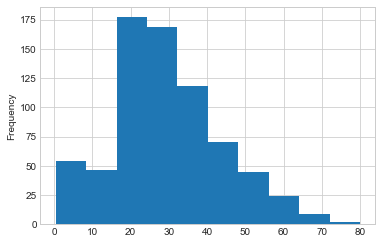

In [8]:
train.Age.plot.hist()

In [9]:
# View the test data (same columns as the training data)
test.head() # head = view first 5 lines

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
# View the example submisison dataframe
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## What missing values are there?

Where are the holes in our data?

These are rows which are missing a value or have NaN instead of something like the rest of the column.

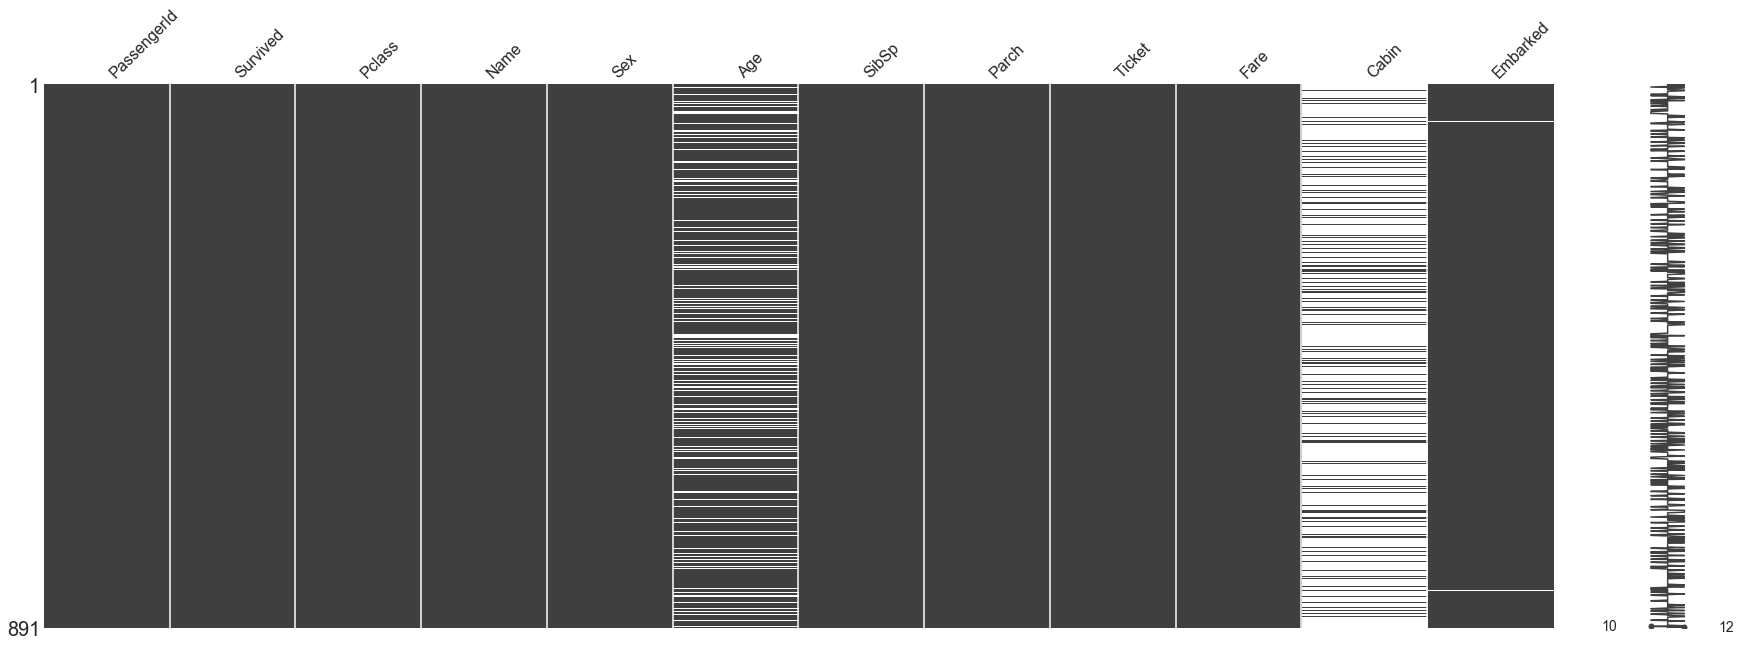

In [12]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10))

Ok we can clearly see some missing values here. Especially in the cabin column.

It's important to visualise missing values early so you know where the major holes are in your dataset.

Knowing this informaiton will help with your EDA and figuring out what kind of data cleaning and preprocessing is needed.

In [33]:
train['Sex'].value_counts()


male      577
female    314
Name: Sex, dtype: int64

In [31]:
#checking missing values without using missingno library
def missing_values(df):
    dfsize = len(df)
    total_missing_values = {}
    for column in df.columns:
        total_entry_values = df[column].value_counts().sum()
        total_missing_values[column] = dfsize - total_entry_values
    return total_missing_values

missing_values = missing_values(train)
missing_values

{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [37]:
# Alternatively, you can see the number of missing values like this
train.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## To perform our data analysis, let's create two new dataframes

We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [38]:
df_bin = pd.DataFrame() # for different interval of continuous range variables (ex 0 - 10 label as 1)
df_con = pd.DataFrame() # for continuous variables

In [39]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Let's explore each of these features individually
We'll go through each column iteratively and see which ones to use in our first models.
Some may need more preprocessing than others to get ready.

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Target Feature: Survived

Description: Whether the passenger survived or not.
    
Key: 0 = did not survive, 1 = survived
    
This is the variable we want our machine learning model to predict based off all the others.

0    549
1    342
Name: Survived, dtype: int64


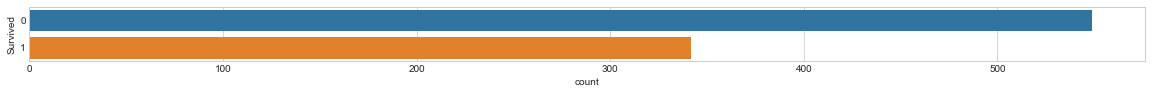

In [13]:
# How many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [40]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [15]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [41]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Feature: Pclass

Description: The ticket class of the passenger.
    
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

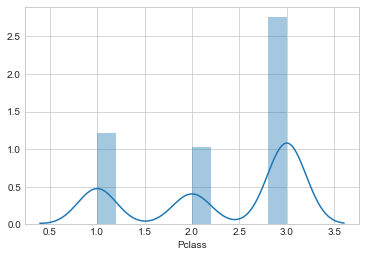

In [17]:
sns.distplot(train.Pclass)

We can see with this feature, the values are numerical (1, 2 and 3) but they are categories.

How do we know this? Because a passenger in Class 3 doesn't necessarily equal a passenger in Class 2 + a passenger in Class 1.

In [42]:
# How many missing variables does Pclass have?
train.Pclass.isnull().sum()

0

Since there are no missing values in Pclass, let's add it to our sub dataframes.

In [45]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [46]:
df_bin.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


In [47]:
df_con.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


### Feature: Name
    
Description: The name of the passenger.

In [48]:
# How many different names are there?
train.Name.value_counts()

Romaine, Mr. Charles Hallace ("Mr C Rolmane")              1
Yasbeck, Mrs. Antoni (Selini Alexander)                    1
Mallet, Mr. Albert                                         1
Rogers, Mr. William John                                   1
Hewlett, Mrs. (Mary D Kingcome)                            1
Karun, Miss. Manca                                         1
Goodwin, Master. William Frederick                         1
Eustis, Miss. Elizabeth Mussey                             1
Nicholson, Mr. Arthur Ernest                               1
Norman, Mr. Robert Douglas                                 1
Lewy, Mr. Ervin G                                          1
Leitch, Miss. Jessie Wills                                 1
Beesley, Mr. Lawrence                                      1
Mellinger, Mrs. (Elizabeth Anne Maidment)                  1
Fry, Mr. Richard                                           1
Brown, Mr. Thomas William Solomon                          1
Stone, Mrs. George Nelso

In [52]:
train['Name'].value_counts()

Romaine, Mr. Charles Hallace ("Mr C Rolmane")              1
Yasbeck, Mrs. Antoni (Selini Alexander)                    1
Mallet, Mr. Albert                                         1
Rogers, Mr. William John                                   1
Hewlett, Mrs. (Mary D Kingcome)                            1
Karun, Miss. Manca                                         1
Goodwin, Master. William Frederick                         1
Eustis, Miss. Elizabeth Mussey                             1
Nicholson, Mr. Arthur Ernest                               1
Norman, Mr. Robert Douglas                                 1
Lewy, Mr. Ervin G                                          1
Leitch, Miss. Jessie Wills                                 1
Beesley, Mr. Lawrence                                      1
Mellinger, Mrs. (Elizabeth Anne Maidment)                  1
Fry, Mr. Richard                                           1
Brown, Mr. Thomas William Solomon                          1
Stone, Mrs. George Nelso

### Feature: Sex

Description: The sex of the passenger (male or female).

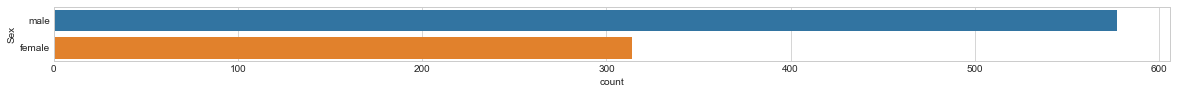

In [55]:
# Let's view the distribution of Sex
plt.figure(figsize=(20, 1))
sns.countplot(y="Sex", data=train);

In [22]:
# Are there any missing values in the Sex column?
train.Sex.isnull().sum()

0

Since this is already binary variable (male or female), let's add it straight to our subset dataframes.

In [23]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [56]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']

In [58]:
df_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


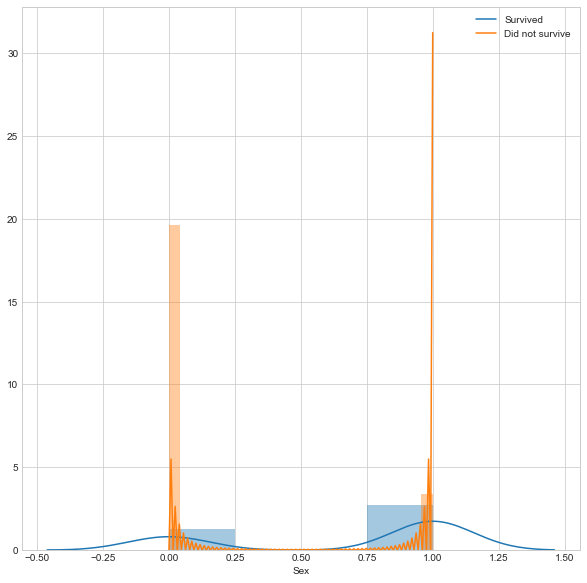

In [25]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

Not many people survived. But of those who did, more were female.

### Feature: Age

Description: The age of the passenger.

In [26]:
# How many missing values does age have?
train.Age.isnull().sum()

177

In [27]:
# Once the Age values have been fixed up, we can add them to our sub dataframes.
# df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
# df_con['Age'] = train['Age'] # non-bucketed

**Challenge:** How would you fill the missing variables in the `Age` column?

#### Function to create count and distribution visualisations

In [59]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

### Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [60]:
# How many missing values does SibSp have?
train.SibSp.isnull().sum()

0

In [61]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Let's add SibSp to our subset dataframes and view the distributions.

In [62]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

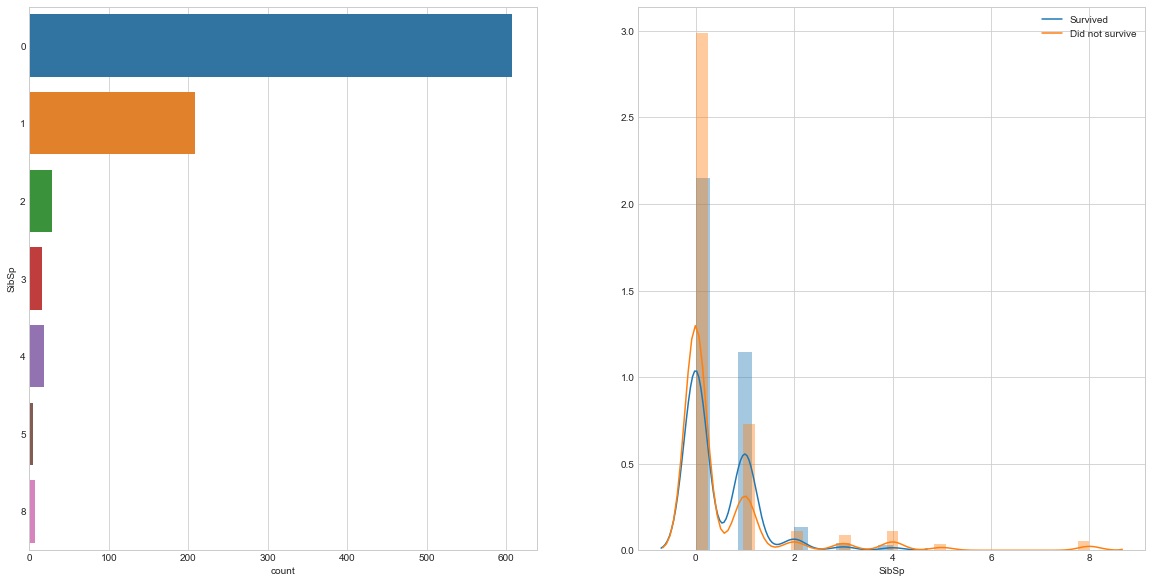

In [63]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

What does the graph on the right tell us?

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.

In [33]:
# How many missing values does Parch have?
train.Parch.isnull().sum()

0

In [34]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [64]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

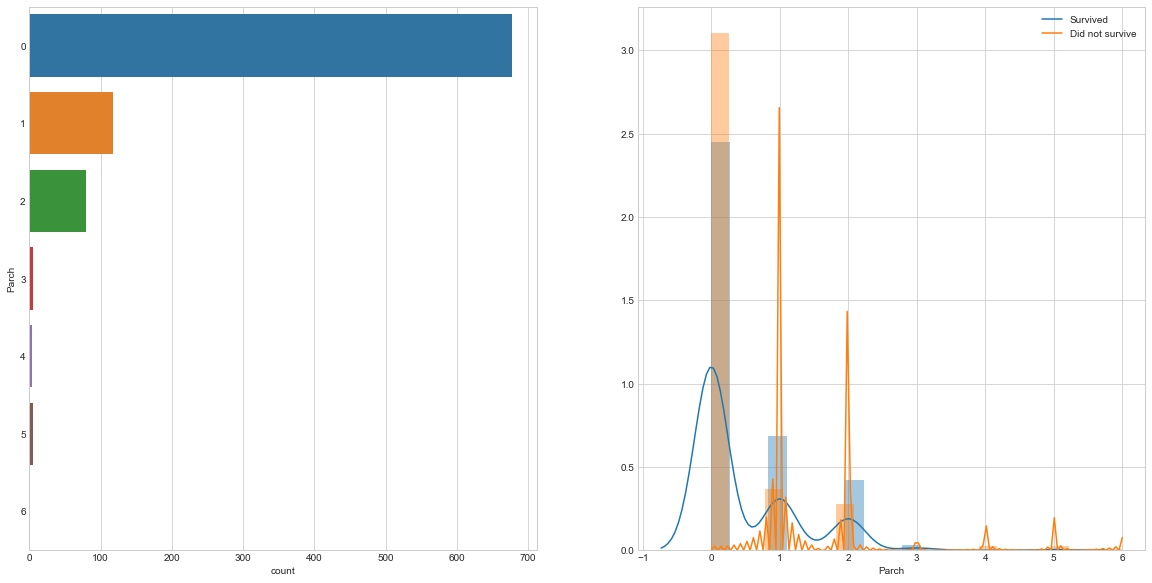

In [65]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

What does the graph on the right tell us about `Parch`?

In [37]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,male,1,0
1,1,1,female,1,0
2,1,3,female,0,0
3,1,1,female,1,0
4,0,3,male,0,0


### Feature: Ticket

Description: The ticket number of the boarding passenger.

In [39]:
# How many missing values does Ticket have?
train.Ticket.isnull().sum()

0

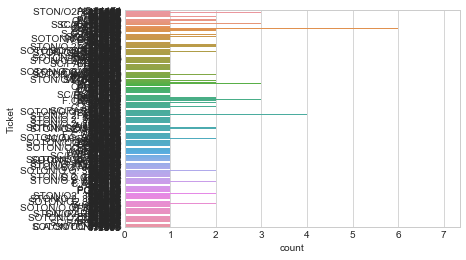

In [40]:
# How many kinds of ticket are there?
sns.countplot(y="Ticket", data=train);

That doesn't look too good, what about another way of looking at it?

In [41]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

347082           7
CA. 2343         7
1601             7
CA 2144          6
347088           6
3101295          6
S.O.C. 14879     5
382652           5
349909           4
2666             4
17421            4
113781           4
LINE             4
W./C. 6608       4
19950            4
347077           4
4133             4
113760           4
PC 17757         4
248727           3
PC 17755         3
371110           3
110413           3
C.A. 34651       3
SC/Paris 2123    3
363291           3
PC 17572         3
PC 17760         3
230080           3
35273            3
                ..
A/5 3540         1
248706           1
C.A. 33595       1
17465            1
239854           1
14313            1
2663             1
6563             1
374887           1
A/5 21172        1
345778           1
349257           1
2647             1
2003             1
330979           1
2693             1
SC/PARIS 2149    1
383121           1
17764            1
4134             1
A/5 3536         1
2685        

In [42]:
# How many unique kinds of Ticket are there?
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


### Feature: Fare

Description: How much the ticket cost.

In [43]:
# How many missing values does Fare have?
train.Fare.isnull().sum()

0

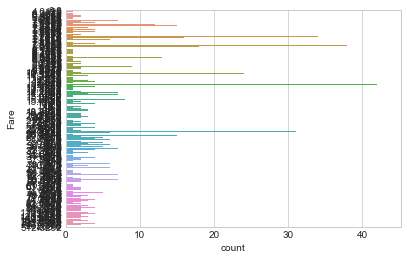

In [44]:
# How many different values of Fare are there?
sns.countplot(y="Fare", data=train);

In [45]:
# What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [46]:
# How many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [66]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised , buckets , intervals

In [68]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,0,1,0,"(-0.512, 102.466]"
1,1,1,1,1,0,"(-0.512, 102.466]"
2,1,3,1,0,0,"(-0.512, 102.466]"
3,1,1,1,1,0,"(-0.512, 102.466]"
4,0,3,0,0,0,"(-0.512, 102.466]"


In [67]:

df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,male,1,0,7.2500
1,1,1,female,1,0,71.2833
2,1,3,female,0,0,7.9250
3,1,1,female,1,0,53.1000
4,0,3,male,0,0,8.0500


In [48]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

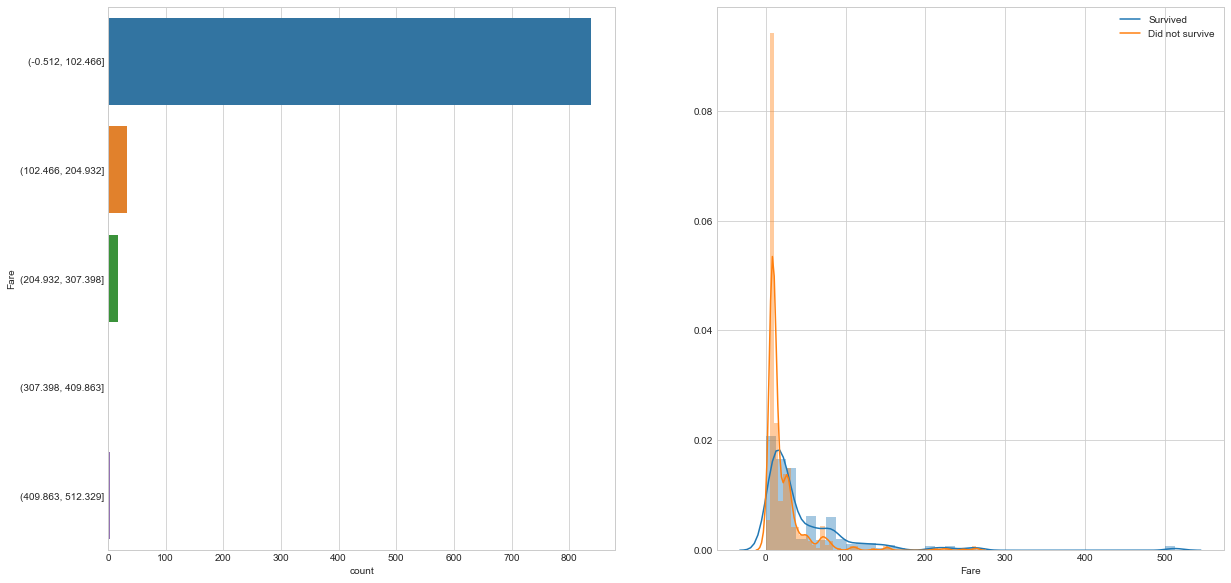

In [69]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

**Challenge:** How would you change the Fare bins?

### Feature: Cabin

Description: The cabin number where the passenger was staying.    

In [50]:
# How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [51]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
# What do the Cabin values look like?
train.Cabin.value_counts()

C23 C25 C27        4
B96 B98            4
G6                 4
F2                 3
D                  3
C22 C26            3
E101               3
F33                3
C126               2
B5                 2
C124               2
B28                2
D35                2
D33                2
E24                2
C125               2
E25                2
C123               2
D20                2
F G73              2
C68                2
C92                2
C52                2
E121               2
D17                2
E8                 2
B57 B59 B63 B66    2
C65                2
D26                2
B20                2
                  ..
B50                1
A20                1
E50                1
B41                1
E58                1
E12                1
A6                 1
D21                1
A23                1
B71                1
F E69              1
C95                1
E68                1
A36                1
E36                1
A32                1
A24          

Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

But how could you modify cabin to be more usable?

What could you do about the missing values?

### Feature: Embarked

Description: The port where the passenger boarded the Titanic.
    
Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [53]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [54]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on.

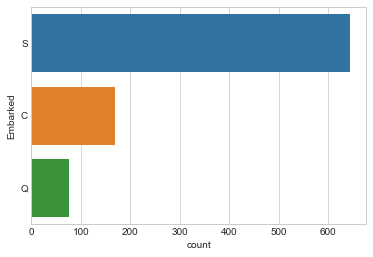

In [55]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

#### How can we deal with the 2 missing values of Embarked?

In [75]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [76]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


We've removed the two rows with missing values for Embarked, now we can add Embarked to our sub dataframes.

## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (`df_bin`) with one-hot encoding and our continuous dataframe (`df_con`) with the label encoding function from `sklearn`.

In [77]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [78]:
columns_name = df_bin.columns.tolist()
columns_name

['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [79]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()  # pass the columns name to one_hot_cols
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [80]:
df_con.head(10)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S
5,0,3,male,0,0,8.4583,Q
6,0,1,male,0,0,51.8625,S
7,0,3,male,3,1,21.0750,S
8,1,3,female,0,2,11.1333,S
9,1,2,female,1,0,30.0708,C


In [83]:
# Label Encode all continuous values using labelEncoder()
df_con_enc = df_con.apply(LabelEncoder().fit_transform)
df_con_enc.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,2,1,1,0,18,2
1,1,0,0,1,0,207,0
2,1,2,0,0,0,41,2
3,1,0,0,1,0,189,2
4,0,2,1,0,0,43,2


In [61]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [62]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [63]:
# Let's look at df_con_enc
df_con_enc.head(20)

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1
5,0,0,0,8.4583,0,1,0,0,1,0,0,1
6,0,0,0,51.8625,0,0,1,0,1,1,0,0
7,0,3,1,21.0750,0,0,1,0,1,0,0,1
8,1,0,2,11.1333,0,0,1,1,0,0,0,1
9,1,1,0,30.0708,1,0,0,1,0,0,1,0


## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Let's seperate the data

In [84]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [85]:
selected_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,2,1,1,0,18,2
1,1,0,0,1,0,207,0
2,1,2,0,0,0,41,2
3,1,0,0,1,0,189,2
4,0,2,1,0,0,43,2


In [86]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [87]:
# Shape of the data (without labels)
X_train.shape

(889, 6)

In [88]:
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [89]:
# Shape of the labels
y_train.shape

(889,)

### Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [90]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [94]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.08
Accuracy CV 10-Fold: 78.52
Running Time: 0:00:02.152304


### K-Nearest Neighbours

In [95]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 81.44
Accuracy CV 10-Fold: 73.68
Running Time: 0:00:00.086268


### Gaussian Naive Bayes

In [96]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 76.72
Accuracy CV 10-Fold: 76.38
Running Time: 0:00:00.032012


### Linear Support Vector Machines (SVC)

In [97]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 63.22
Accuracy CV 10-Fold: 67.6
Running Time: 0:00:00.133311


### Stochastic Gradient Descent

In [98]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 70.64
Accuracy CV 10-Fold: 62.88
Running Time: 0:00:00.055779


### Decision Tree Classifier

In [99]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 79.75
Running Time: 0:00:00.065903


### Gradient Boost Trees

In [100]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.39
Accuracy CV 10-Fold: 81.1
Running Time: 0:00:00.254840


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

In [101]:
# View the data for the CatBoost model
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [102]:
# View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [104]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([0, 1, 2, 3, 4, 5])

This means Catboost has picked up that all variables except `Fare` can be treated as categorical.

In [106]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

NameError: name 'Pool' is not defined

In [105]:
train_pool


NameError: name 'train_pool' is not defined

In [82]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [83]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.016206


0:	learn: 0.6819672	total: 98.7ms	remaining: 1m 38s
1:	learn: 0.6733233	total: 138ms	remaining: 1m 8s
2:	learn: 0.6644361	total: 170ms	remaining: 56.5s
3:	learn: 0.6579933	total: 200ms	remaining: 49.8s
4:	learn: 0.6510365	total: 235ms	remaining: 46.8s
5:	learn: 0.6437724	total: 263ms	remaining: 43.5s
6:	learn: 0.6361234	total: 292ms	remaining: 41.4s
7:	learn: 0.6287414	total: 325ms	remaining: 40.3s
8:	learn: 0.6225296	total: 361ms	remaining: 39.7s
9:	learn: 0.6156731	total: 387ms	remaining: 38.3s
10:	learn: 0.6108103	total: 414ms	remaining: 37.2s
11:	learn: 0.6059871	total: 439ms	remaining: 36.2s
12:	learn: 0.6019392	total: 466ms	remaining: 35.4s
13:	learn: 0.5975850	total: 839ms	remaining: 59.1s
14:	learn: 0.5916863	total: 933ms	remaining: 1m 1s
15:	learn: 0.5876791	total: 1.05s	remaining: 1m 4s
16:	learn: 0.5843881	total: 1.09s	remaining: 1m 2s
17:	learn: 0.5792108	total: 1.11s	remaining: 1m
18:	learn: 0.5732864	total: 1.16s	remaining: 59.8s
19:	learn: 0.5668497	total: 1.19s	remainin

168:	learn: 0.4234589	total: 4.78s	remaining: 23.5s
169:	learn: 0.4232936	total: 4.81s	remaining: 23.5s
170:	learn: 0.4229176	total: 4.84s	remaining: 23.5s
171:	learn: 0.4228959	total: 4.86s	remaining: 23.4s
172:	learn: 0.4226165	total: 4.89s	remaining: 23.4s
173:	learn: 0.4222932	total: 4.91s	remaining: 23.3s
174:	learn: 0.4221613	total: 4.92s	remaining: 23.2s
175:	learn: 0.4218527	total: 4.94s	remaining: 23.1s
176:	learn: 0.4217775	total: 4.95s	remaining: 23s
177:	learn: 0.4217535	total: 4.96s	remaining: 22.9s
178:	learn: 0.4216979	total: 4.97s	remaining: 22.8s
179:	learn: 0.4216288	total: 5s	remaining: 22.8s
180:	learn: 0.4216195	total: 5.02s	remaining: 22.7s
181:	learn: 0.4215867	total: 5.03s	remaining: 22.6s
182:	learn: 0.4212857	total: 5.04s	remaining: 22.5s
183:	learn: 0.4211462	total: 5.06s	remaining: 22.4s
184:	learn: 0.4210967	total: 5.08s	remaining: 22.4s
185:	learn: 0.4207163	total: 5.1s	remaining: 22.3s
186:	learn: 0.4207142	total: 5.12s	remaining: 22.3s
187:	learn: 0.4207

332:	learn: 0.4040813	total: 7.97s	remaining: 16s
333:	learn: 0.4040660	total: 7.99s	remaining: 15.9s
334:	learn: 0.4038754	total: 8s	remaining: 15.9s
335:	learn: 0.4036781	total: 8.02s	remaining: 15.8s
336:	learn: 0.4036456	total: 8.03s	remaining: 15.8s
337:	learn: 0.4035908	total: 8.05s	remaining: 15.8s
338:	learn: 0.4035908	total: 8.05s	remaining: 15.7s
339:	learn: 0.4035424	total: 8.07s	remaining: 15.7s
340:	learn: 0.4035193	total: 8.08s	remaining: 15.6s
341:	learn: 0.4034573	total: 8.1s	remaining: 15.6s
342:	learn: 0.4033857	total: 8.11s	remaining: 15.5s
343:	learn: 0.4033687	total: 8.12s	remaining: 15.5s
344:	learn: 0.4032211	total: 8.14s	remaining: 15.4s
345:	learn: 0.4030282	total: 8.16s	remaining: 15.4s
346:	learn: 0.4030131	total: 8.17s	remaining: 15.4s
347:	learn: 0.4030108	total: 8.19s	remaining: 15.3s
348:	learn: 0.4030108	total: 8.19s	remaining: 15.3s
349:	learn: 0.4029789	total: 8.21s	remaining: 15.2s
350:	learn: 0.4029156	total: 8.22s	remaining: 15.2s
351:	learn: 0.4027

492:	learn: 0.3932085	total: 10.7s	remaining: 11s
493:	learn: 0.3931997	total: 10.7s	remaining: 11s
494:	learn: 0.3931535	total: 10.8s	remaining: 11s
495:	learn: 0.3929410	total: 10.8s	remaining: 10.9s
496:	learn: 0.3928943	total: 10.8s	remaining: 10.9s
497:	learn: 0.3928731	total: 10.8s	remaining: 10.9s
498:	learn: 0.3928524	total: 10.8s	remaining: 10.9s
499:	learn: 0.3928165	total: 10.8s	remaining: 10.8s
500:	learn: 0.3927637	total: 10.8s	remaining: 10.8s
501:	learn: 0.3927252	total: 10.9s	remaining: 10.8s
502:	learn: 0.3926516	total: 10.9s	remaining: 10.7s
503:	learn: 0.3925057	total: 10.9s	remaining: 10.7s
504:	learn: 0.3924505	total: 10.9s	remaining: 10.7s
505:	learn: 0.3924410	total: 11s	remaining: 10.7s
506:	learn: 0.3921605	total: 11s	remaining: 10.7s
507:	learn: 0.3920970	total: 11.1s	remaining: 10.7s
508:	learn: 0.3920897	total: 11.1s	remaining: 10.7s
509:	learn: 0.3920610	total: 11.2s	remaining: 10.7s
510:	learn: 0.3918965	total: 11.2s	remaining: 10.7s
511:	learn: 0.3918286	

657:	learn: 0.3754748	total: 14.4s	remaining: 7.48s
658:	learn: 0.3754152	total: 14.4s	remaining: 7.46s
659:	learn: 0.3752489	total: 14.4s	remaining: 7.44s
660:	learn: 0.3751624	total: 14.5s	remaining: 7.42s
661:	learn: 0.3750391	total: 14.5s	remaining: 7.41s
662:	learn: 0.3749075	total: 14.5s	remaining: 7.38s
663:	learn: 0.3748751	total: 14.5s	remaining: 7.36s
664:	learn: 0.3747467	total: 14.6s	remaining: 7.33s
665:	learn: 0.3747224	total: 14.6s	remaining: 7.31s
666:	learn: 0.3747224	total: 14.6s	remaining: 7.28s
667:	learn: 0.3746803	total: 14.6s	remaining: 7.25s
668:	learn: 0.3745962	total: 14.6s	remaining: 7.23s
669:	learn: 0.3745229	total: 14.6s	remaining: 7.21s
670:	learn: 0.3744180	total: 14.7s	remaining: 7.18s
671:	learn: 0.3743694	total: 14.7s	remaining: 7.16s
672:	learn: 0.3742757	total: 14.7s	remaining: 7.13s
673:	learn: 0.3742423	total: 14.7s	remaining: 7.11s
674:	learn: 0.3740395	total: 14.7s	remaining: 7.08s
675:	learn: 0.3740229	total: 14.7s	remaining: 7.06s
676:	learn: 

821:	learn: 0.3635097	total: 17.7s	remaining: 3.82s
822:	learn: 0.3634941	total: 17.7s	remaining: 3.81s
823:	learn: 0.3634791	total: 17.7s	remaining: 3.78s
824:	learn: 0.3634251	total: 17.7s	remaining: 3.76s
825:	learn: 0.3628887	total: 17.8s	remaining: 3.74s
826:	learn: 0.3628356	total: 17.8s	remaining: 3.72s
827:	learn: 0.3627977	total: 17.8s	remaining: 3.69s
828:	learn: 0.3627855	total: 17.8s	remaining: 3.67s
829:	learn: 0.3627752	total: 17.8s	remaining: 3.65s
830:	learn: 0.3627222	total: 17.8s	remaining: 3.63s
831:	learn: 0.3627199	total: 17.9s	remaining: 3.61s
832:	learn: 0.3626697	total: 17.9s	remaining: 3.59s
833:	learn: 0.3625811	total: 17.9s	remaining: 3.56s
834:	learn: 0.3625663	total: 17.9s	remaining: 3.54s
835:	learn: 0.3624836	total: 17.9s	remaining: 3.52s
836:	learn: 0.3624433	total: 18s	remaining: 3.5s
837:	learn: 0.3623300	total: 18s	remaining: 3.48s
838:	learn: 0.3620453	total: 18s	remaining: 3.45s
839:	learn: 0.3620016	total: 18s	remaining: 3.43s
840:	learn: 0.3619852

980:	learn: 0.3541389	total: 20.7s	remaining: 400ms
981:	learn: 0.3541255	total: 20.7s	remaining: 379ms
982:	learn: 0.3541117	total: 20.7s	remaining: 358ms
983:	learn: 0.3539459	total: 20.7s	remaining: 337ms
984:	learn: 0.3538802	total: 20.7s	remaining: 316ms
985:	learn: 0.3538663	total: 20.8s	remaining: 295ms
986:	learn: 0.3538594	total: 20.8s	remaining: 274ms
987:	learn: 0.3538277	total: 20.8s	remaining: 252ms
988:	learn: 0.3537966	total: 20.8s	remaining: 231ms
989:	learn: 0.3536281	total: 20.8s	remaining: 210ms
990:	learn: 0.3536040	total: 20.8s	remaining: 189ms
991:	learn: 0.3535921	total: 20.9s	remaining: 168ms
992:	learn: 0.3535592	total: 20.9s	remaining: 147ms
993:	learn: 0.3535497	total: 20.9s	remaining: 126ms
994:	learn: 0.3532564	total: 20.9s	remaining: 105ms
995:	learn: 0.3532189	total: 20.9s	remaining: 84.1ms
996:	learn: 0.3532052	total: 21s	remaining: 63.1ms
997:	learn: 0.3531328	total: 21s	remaining: 42ms
998:	learn: 0.3530687	total: 21s	remaining: 21ms
999:	learn: 0.3530

### Perform CatBoost cross-validation

In [84]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6832959	test: 0.6836769	best: 0.6836769 (0)
1:	learn: 0.6741556	test: 0.6748678	best: 0.6748678 (1)
2:	learn: 0.6666448	test: 0.6675199	best: 0.6675199 (2)
3:	learn: 0.6581527	test: 0.6596288	best: 0.6596288 (3)
4:	learn: 0.6503888	test: 0.6521354	best: 0.6521354 (4)
5:	learn: 0.6436360	test: 0.6457592	best: 0.6457592 (5)
6:	learn: 0.6374098	test: 0.6398631	best: 0.6398631 (6)
7:	learn: 0.6306943	test: 0.6335851	best: 0.6335851 (7)
8:	learn: 0.6244111	test: 0.6274241	best: 0.6274241 (8)
9:	learn: 0.6178949	test: 0.6209999	best: 0.6209999 (9)
10:	learn: 0.6118778	test: 0.6151771	best: 0.6151771 (10)
11:	learn: 0.6059909	test: 0.6097940	best: 0.6097940 (11)
12:	learn: 0.6008831	test: 0.6049036	best: 0.6049036 (12)
13:	learn: 0.5950573	test: 0.5992945	best: 0.5992945 (13)
14:	learn: 0.5900124	test: 0.5942713	best: 0.5942713 (14)	total: 4.22s	remaining: 4m 37s
15:	learn: 0.5851994	test: 0.5895529	best: 0.5895529 (15)
16:	learn: 0.5801656	test: 0.5848803	best: 0.5848803 (16)
17:

163:	learn: 0.4215019	test: 0.4494910	best: 0.4494910 (163)
164:	learn: 0.4212709	test: 0.4494270	best: 0.4494270 (164)
165:	learn: 0.4210137	test: 0.4493236	best: 0.4493236 (165)
166:	learn: 0.4208601	test: 0.4491996	best: 0.4491996 (166)
167:	learn: 0.4206969	test: 0.4492126	best: 0.4491996 (166)
168:	learn: 0.4204826	test: 0.4491355	best: 0.4491355 (168)
169:	learn: 0.4202014	test: 0.4490328	best: 0.4490328 (169)
170:	learn: 0.4200883	test: 0.4489399	best: 0.4489399 (170)
171:	learn: 0.4198782	test: 0.4487787	best: 0.4487787 (171)
172:	learn: 0.4197881	test: 0.4487184	best: 0.4487184 (172)
173:	learn: 0.4196023	test: 0.4486994	best: 0.4486994 (173)
174:	learn: 0.4193605	test: 0.4486637	best: 0.4486637 (174)
175:	learn: 0.4192620	test: 0.4486462	best: 0.4486462 (175)
176:	learn: 0.4190553	test: 0.4486368	best: 0.4486368 (176)
177:	learn: 0.4189223	test: 0.4484767	best: 0.4484767 (177)
178:	learn: 0.4187903	test: 0.4484359	best: 0.4484359 (178)
179:	learn: 0.4186354	test: 0.4484223	be

429:	learn: 0.3973106	test: 0.4433273	best: 0.4433273 (429)
430:	learn: 0.3972757	test: 0.4432939	best: 0.4432939 (430)
431:	learn: 0.3971652	test: 0.4432920	best: 0.4432920 (431)
432:	learn: 0.3971019	test: 0.4432933	best: 0.4432920 (431)
433:	learn: 0.3970669	test: 0.4432989	best: 0.4432920 (431)
434:	learn: 0.3969977	test: 0.4432040	best: 0.4432040 (434)
435:	learn: 0.3969456	test: 0.4432230	best: 0.4432040 (434)
436:	learn: 0.3969130	test: 0.4432032	best: 0.4432032 (436)
437:	learn: 0.3968441	test: 0.4432075	best: 0.4432032 (436)
438:	learn: 0.3968001	test: 0.4432332	best: 0.4432032 (436)
439:	learn: 0.3967556	test: 0.4432244	best: 0.4432032 (436)
440:	learn: 0.3966900	test: 0.4432610	best: 0.4432032 (436)
441:	learn: 0.3966246	test: 0.4432512	best: 0.4432032 (436)
442:	learn: 0.3965815	test: 0.4432518	best: 0.4432032 (436)
443:	learn: 0.3965084	test: 0.4432454	best: 0.4432032 (436)
444:	learn: 0.3964718	test: 0.4432330	best: 0.4432032 (436)
445:	learn: 0.3963826	test: 0.4432739	be

843:	learn: 0.3640219	test: 0.4405076	best: 0.4404269 (836)
844:	learn: 0.3640000	test: 0.4405105	best: 0.4404269 (836)
845:	learn: 0.3639297	test: 0.4405003	best: 0.4404269 (836)
846:	learn: 0.3638210	test: 0.4404969	best: 0.4404269 (836)
847:	learn: 0.3637876	test: 0.4405206	best: 0.4404269 (836)
848:	learn: 0.3636921	test: 0.4404815	best: 0.4404269 (836)
849:	learn: 0.3636316	test: 0.4404986	best: 0.4404269 (836)
850:	learn: 0.3634671	test: 0.4405829	best: 0.4404269 (836)
851:	learn: 0.3634248	test: 0.4405866	best: 0.4404269 (836)
852:	learn: 0.3633933	test: 0.4405835	best: 0.4404269 (836)
853:	learn: 0.3633259	test: 0.4405529	best: 0.4404269 (836)
854:	learn: 0.3632542	test: 0.4405767	best: 0.4404269 (836)
855:	learn: 0.3631967	test: 0.4405232	best: 0.4404269 (836)
856:	learn: 0.3630979	test: 0.4405711	best: 0.4404269 (836)
857:	learn: 0.3630279	test: 0.4405176	best: 0.4404269 (836)
858:	learn: 0.3629844	test: 0.4405087	best: 0.4404269 (836)
859:	learn: 0.3629286	test: 0.4405571	be

In [85]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 83.13
Accuracy cross-validation 10-Fold: 80.99
Running Time: 0:03:57.047122


## Model Results
Which model had the best cross-validation accuracy?



### Regular accuracy scores

In [86]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.46
6,Gradient Boosting Trees,86.61
0,KNN,83.46
7,CatBoost,83.13
1,Logistic Regression,79.98
2,Naive Bayes,78.52
3,Stochastic Gradient Decent,72.10
4,Linear SVC,68.84


In [87]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,80.99
6,Gradient Boosting Trees,80.65
5,Decision Tree,80.09
1,Logistic Regression,79.42
2,Naive Bayes,77.95
4,Linear SVC,77.28
0,KNN,76.72
3,Stochastic Gradient Decent,72.10


## Feature Importance
Which features of the best model were most important for making predictions?

In [88]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

,imp,col
4,0.781810,embarked_Q
3,0.976139,embarked_C
5,0.995272,embarked_S
9,2.811305,pclass_2
8,4.888194,pclass_1
0,8.300626,SibSp
10,10.623853,pclass_3
1,12.308192,Parch
2,17.315740,Fare
6,20.294736,sex_female


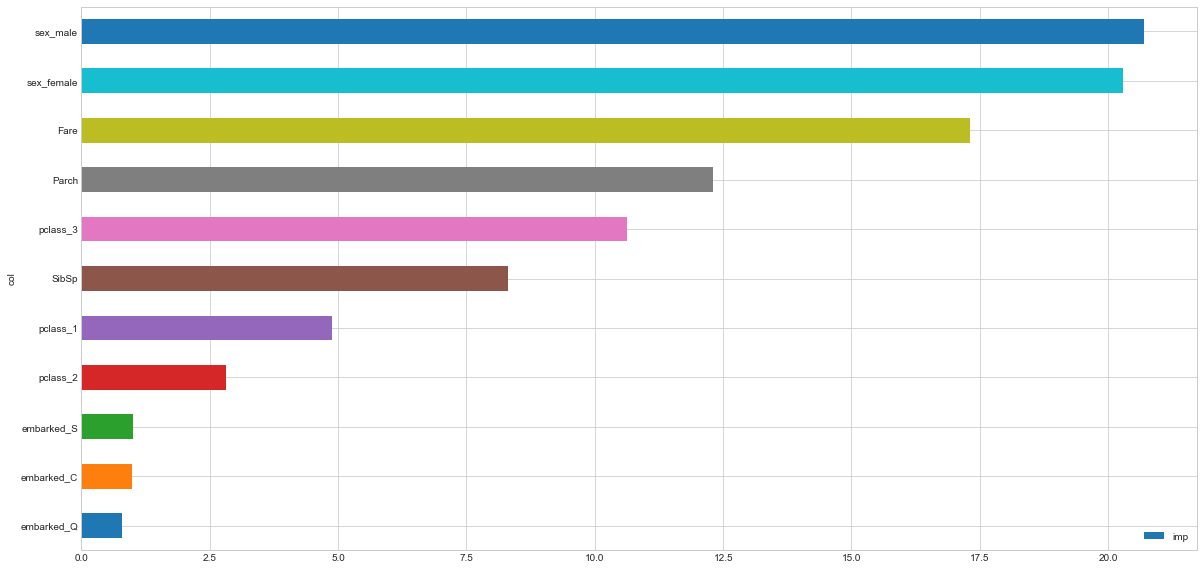

In [89]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

#### Why would you want feature importance?

Featrue importance shows how much each feature contributed to the model.

You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

You could improve features which don't offer much to the overall model.

Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

In [90]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

Precision: 0.8232190544093455
Recall: 0.6712852941176471
F1: 0.7392883787836901
AUC: 0.8800940292510447


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Submission
Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the `test` dateframe, encode them and make a prediciton with our model.

In [91]:
# We need our test dataframe to look like this one
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [92]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [93]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [94]:
# Combine the test one hot encoded columns with test
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [95]:
# Let's look at test, it should have one hot encoded columns now
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


In [96]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [97]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns])

In [98]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1.])

In [99]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0


In [100]:
# What does our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


We need our `submission` dataframe to look like the `gender_submisison` dataframe, so we'll turn the `Survived` column into integers.

In [101]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [102]:
# How does our submission dataframe look?
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [103]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [104]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('../catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [105]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
